In [40]:
import os
import tarfile
from six.moves import urllib

In [41]:
DOWNLOAD_ROOT="https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH=os.path.join("datasets", "housing")
HOUSING_URL=DOWNLOAD_ROOT+"datasets/housing/housing.tgz"

In [42]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        
    tgz_path=os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
        
    housing_tgz=tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [43]:
fetch_housing_data()

In [44]:
import pandas as pd

In [45]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path=os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [46]:
housing=load_housing_data()

# `Explore the data`

In [47]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [48]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [49]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [50]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


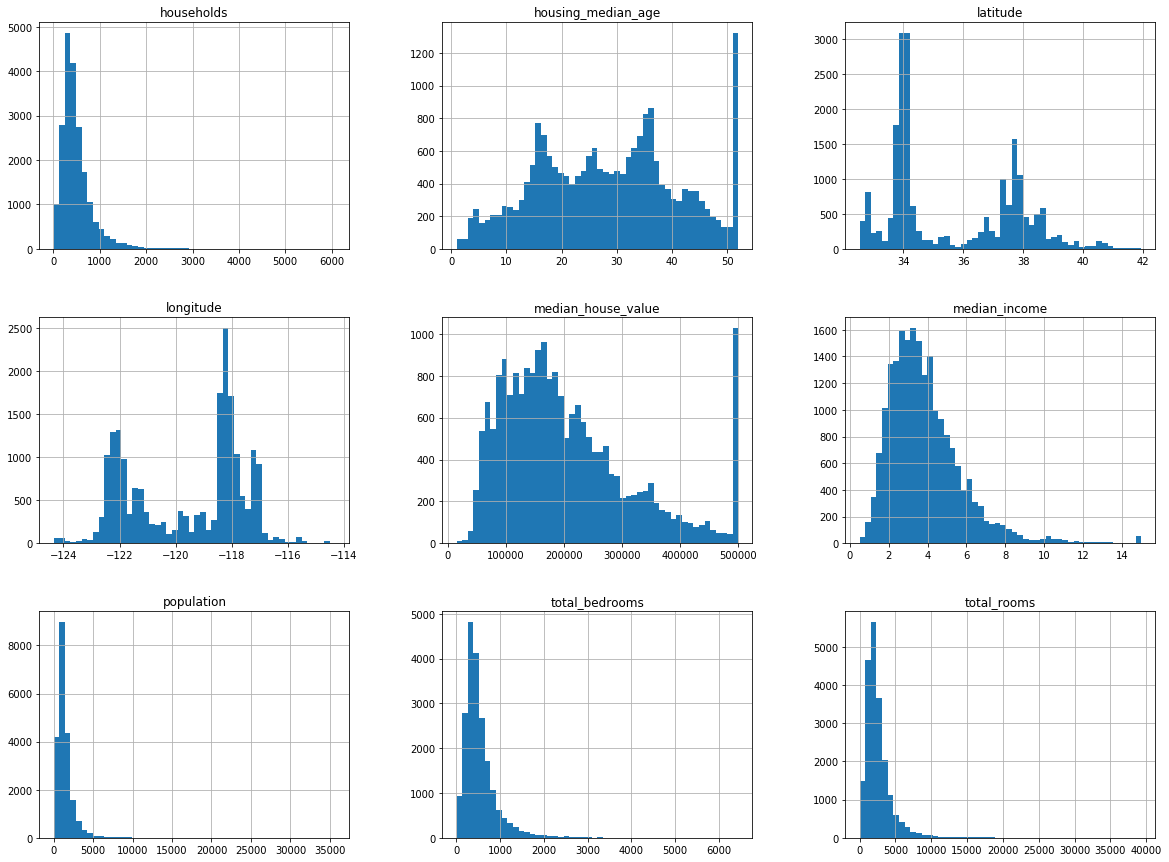

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

# `Create the test set`

In [52]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices=np.random.permutation(len(data))
    test_set_size=int(len(data)*test_ratio)
    test_indices=shuffled_indices[:test_set_size]
    train_indices=shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


In [53]:
train_set, test_set = split_train_test(housing, 0.2)

In [54]:
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


**Note:** We need to avoid ever exposing test instances to the training algorithm.  So far we haven't prevented that: the function **`split_train_test`** will create a new mix of training and test instances every time it's executed.  Setting random number generator seed in the function would work if the data never gets refreshed.  If the data is refreshed and contains new instances on consequent refreshes, the following solution will keep the test instances from infiltrating the training set.  It uses hashes of the instance identifiers as the ID based on which each set is created.   

In [55]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    # compare the last byte of the identifier hash (256 possible unique vlues) 
    # with the test_ratio threshold  
    return hash(np.int64(identifier)).digest()[-1] < 256*test_ratio


def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set=ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]


In [56]:
#since our housing data doesn't have an ID column, we create it(in a new data-set):
housing_with_id = housing.reset_index()

In [57]:
housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [58]:
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

This solution will work if we know for sure that as the data grows, the new data gets appended to the dataset and no rows get deleted.  If we can't be sure of that, we should use "the most stable" data attributes to synthesize the ID column as shown below:

In [59]:
housing_with_id["id"] = housing["longitude"]*1000+housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

better yet, use scikit-learn's built-in function fo splitting data-sets: **`train_test_split`**:

In [60]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

## `Stratified sampling`

As we create a training set, we need to be mindful of stratum bias: it is important to have a sufficient number of instances in you dataset for each **`stratum`** or else the estimate of the stratum's importance may be biased.

In [61]:
#here we create a new 5-category attribute based on the median_incom column:
housing["income_cat"]=np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"]<5, 5.0, inplace=True) #group all the outliers above cat 5 into cat 5

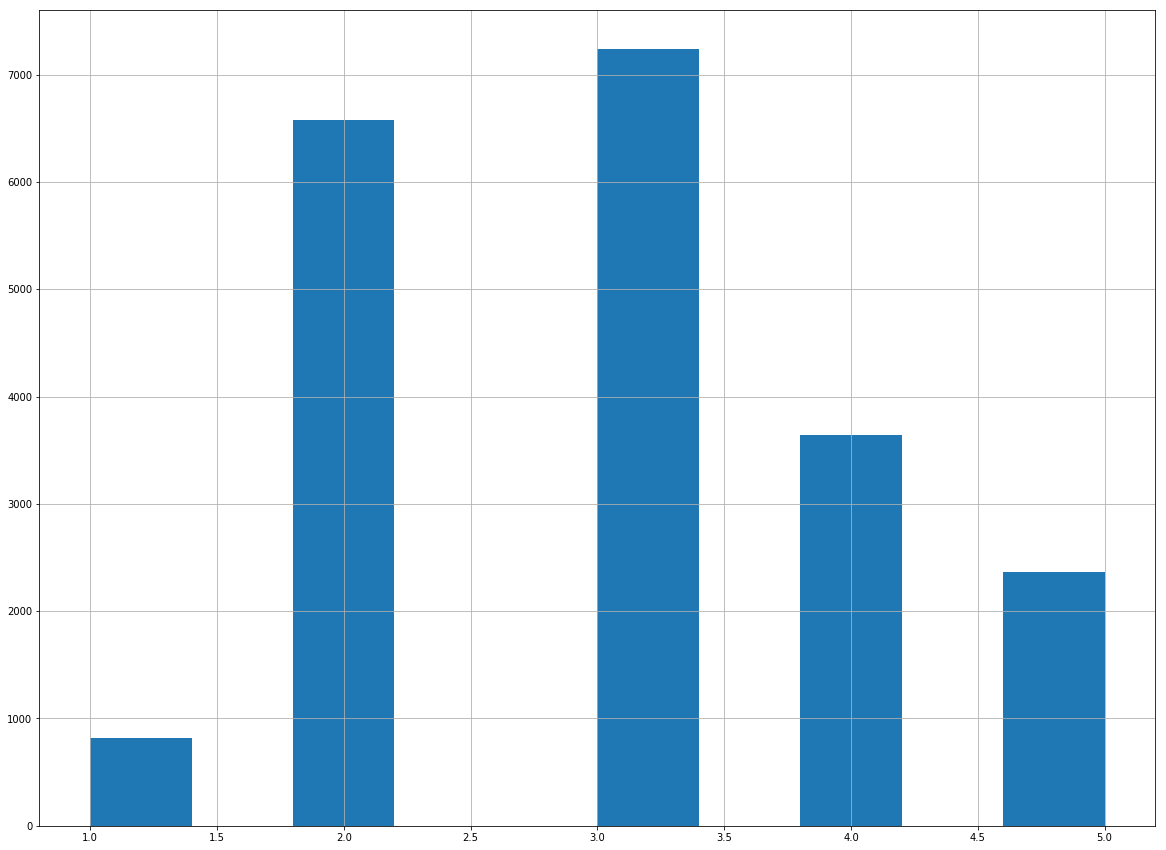

In [62]:
%matplotlib inline
housing["income_cat"].hist(figsize=(20,15))
plt.show()

...and now we can perform stratified sampling using the new column:

In [63]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


In [35]:
split.dd

AttributeError: 'StratifiedShuffleSplit' object has no attribute 'type'

In [64]:
#let's look what we got:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [65]:
#for comparison:
housing["income_cat"].value_counts()/len(housing["income_cat"])

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

**Conclusion:**  the test when created with stratified sampling is almost perfectly representative of the entire set. It would not be the case if we performed purely random sampling.

In [66]:
#cleaning up: remove income_cat attribure as it's no longer needed
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Discover and Visualize the Data to Gain Insights

First: put the test set aside and only explore the training set.

In [67]:
# Then we create a copy of the training set for poking and prodding without harming the training set itself:
housing = strat_train_set.copy()

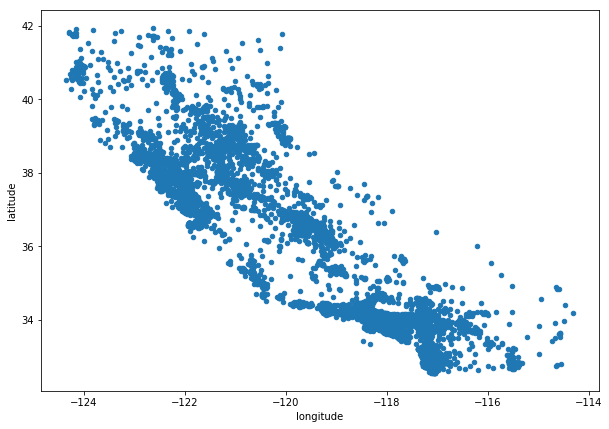

In [88]:
# Create scatterplot:
housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7))
plt.show()
#setting the alpha parameter helps to vizualize density of the scatterplot

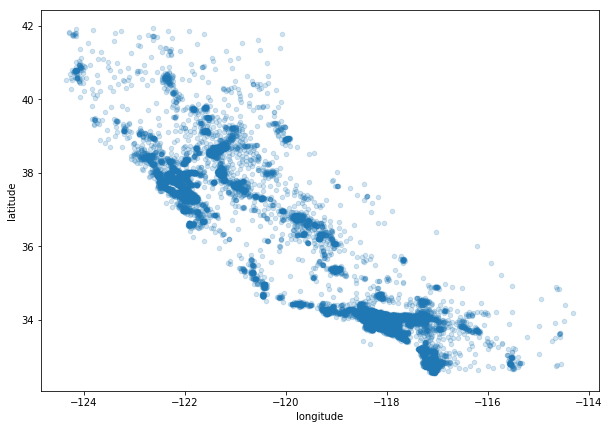

In [87]:
#Modification: set the alpha parameter
housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7), alpha=0.2)
plt.show()

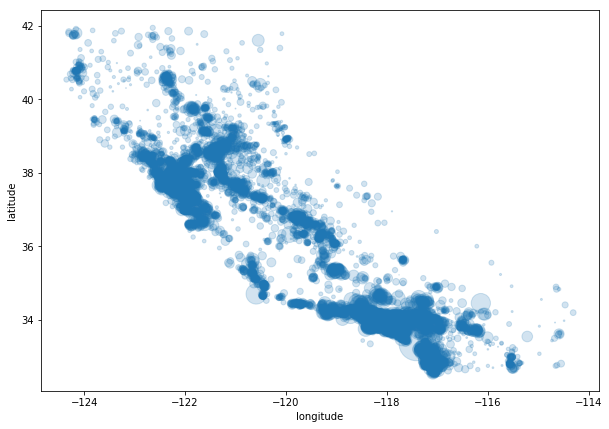

In [94]:
#Modification: set the size parameter s
housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7), alpha=0.2, 
            s=housing["population"]/30)
plt.show()

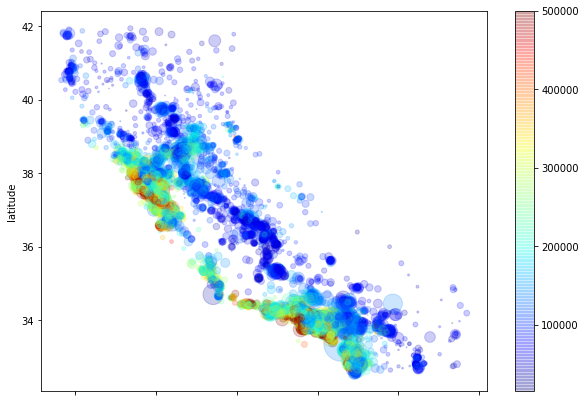

In [100]:
#Modification: set the color parameter parameter c
housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7), alpha=0.2, 
            s=housing["population"]/30, c=housing["median_house_value"], 
             cmap=plt.get_cmap("jet"),
            colorbar=True)
plt.legend()
